In [1]:
import argparse
import logging
import math
import os
import random
import time
import csv
import cv2
from numpy.lib.function_base import rot90
import scipy.ndimage
import json
import matplotlib.pyplot as plt

from hrnet.lib.config import config,update_config
from hrnet import hrnet
from hrnet.utils import utils
from hrnet.core.evaluation import compute_nme, compute_nme_horse, compute_nme_point, compute_shift, compute_shift_pre,decode_preds
from hrnet.utils.transforms import fliplr_joints, crop, generate_target_inverse, transform_pixel


import numpy as np
import torch
import wandb
from torch import nn, optim
from torch.cuda import amp
from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from hrnet.data.animalweb import read_pts


from utils import (AverageMeter, accuracy, create_loss_fn,
                   model_load_state_dict, reduce_tensor, save_checkpoint)

/home/hsc/anaconda3/envs/pytorch/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logger = logging.getLogger(__name__)

parser = argparse.ArgumentParser()
parser.add_argument('--cfg', help='experiment configuration filename',
                        required=True, type=str)
parser.add_argument('--name', type=str, required=True, help='experiment name')
parser.add_argument('--data-path', default='./data', type=str, help='data path')
parser.add_argument('--save-path', default='./checkpoint3', type=str, help='save path')
parser.add_argument('--dataset', default='animalweb', type=str,
                    choices=['cifar10', 'cifar100','animalweb'], help='dataset name')
parser.add_argument('--num-labeled', type=int, default=4000, help='number of labeled data')
# parser.add_argument("--expand-labels", action="store_true", help="expand labels to fit eval steps")
parser.add_argument('--total-steps', default=300000, type=int, help='number of total steps to run')
parser.add_argument('--eval-step', default=1000, type=int, help='number of eval steps to run')
parser.add_argument('--start-step', default=0, type=int,
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--workers', default=4, type=int, help='number of workers')
parser.add_argument('--student-wait-steps', default=0, type=int, help='warmup steps')
parser.add_argument('--grad-clip', default=0., type=float, help='gradient norm clipping')
parser.add_argument('--resume', default='', type=str, help='path to checkpoint')
parser.add_argument('--evaluate', action='store_true', help='only evaluate model on validation set')
parser.add_argument('--finetune', action='store_true',
                    help='only finetune model on labeled dataset')
parser.add_argument('--finetune-epochs', default=125, type=int, help='finetune epochs')
parser.add_argument('--finetune-batch-size', default=512, type=int, help='finetune batch size')
parser.add_argument('--finetune-lr', default=1e-5, type=float, help='finetune learning late')
parser.add_argument('--finetune-weight-decay', default=0, type=float, help='finetune weight decay')
parser.add_argument('--finetune-momentum', default=0, type=float, help='finetune SGD Momentum')
parser.add_argument('--seed', default=None, type=int, help='seed for initializing training')
parser.add_argument('--lambda-u', default=1, type=float, help='coefficient of unlabeled loss')
parser.add_argument('--uda-steps', default=1, type=float, help='warmup steps of lambda-u')
parser.add_argument("--amp", action="store_true", help="use 16-bit (mixed) precision")
parser.add_argument('--world-size', default=-1, type=int,
                    help='number of nodes for distributed training')
parser.add_argument("--local_rank", type=int, default=-1,
                    help="For distributed training: local_rank")
parser.add_argument('--vis', action='store_true',
                    help='output the img of test set')


_StoreTrueAction(option_strings=['--vis'], dest='vis', nargs=0, const=True, default=False, type=None, choices=None, help='output the img of test set', metavar=None)

Assign the image to test;

Assign the model to use;

In [3]:
imgname = [ 'horse/im/flickr-horses/203.jpg', 
            'horse/im/flickr-horses/2756.jpg',
            'horse/im/flickr-horses/6189.jpg', 
            'horse/im/imagenet_n02374451/n02374451_2809.jpg']
            
model_name = 'checkpoint_horse/horse.pth.tar' #change it to the model you want to use

In [4]:
args = parser.parse_args(args=['--cfg','./experiment/horse_test.yaml','--name','test_horse','--vis','--resume',model_name])

In [5]:
import os
import random

import torch
import torch.utils.data as data
import pandas as pd
from PIL import Image, ImageFile
import numpy as np
import json
import copy

from hrnet.utils.transforms import fliplr_joints, crop, generate_target, transform_pixel

ImageFile.LOAD_TRUNCATED_IMAGES = True


def read_pts(filename):
    return np.loadtxt(filename, comments=("version:", "n_points:", "{", "}"))


class AnimalWeb(data.Dataset):
    """AFLW
    """
    def __init__(self, cfg, args, label = True, is_train=True):
        # specify annotation file for dataset
        self.label = label
        self.is_train = is_train
        if is_train:
            if label:
                self.txt_file = cfg.DATASET.TRAINSET
            else:
                self.txt_file = cfg.DATASET.UNLABELSET
            # visfile = '../data/animal/vis.json'
            # with open(visfile,'r') as vis_file:
            #     self.visdata = json.load(vis_file)
        else:
            if args.evaluate:
                self.txt_file = cfg.DATASET.TESTSET
            else:
                self.txt_file = cfg.DATASET.VALSET
            
        self.bbox_file = cfg.DATASET.BBOX
        self.is_train = is_train
        self.data_root = cfg.DATASET.ROOT
        self.input_size = cfg.MODEL.IMAGE_SIZE
        self.output_size = cfg.MODEL.HEATMAP_SIZE
        self.sigma = cfg.MODEL.SIGMA
        self.weak_scale_factor = cfg.DATASET.WEAK_SCALE_FACTOR
        self.weak_rot_factor = cfg.DATASET.WEAK_ROT_FACTOR
        self.strong_scale_factor = cfg.DATASET.STRONG_SCALE_FACTOR
        self.strong_rot_factor = cfg.DATASET.STRONG_ROT_FACTOR

        self.label_type = cfg.MODEL.TARGET_TYPE

        self.flip = cfg.DATASET.FLIP

        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        self.std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

        # load annotations
        self.landmarks_frame = imgname
        self.bbox_data = pd.read_csv(self.bbox_file)
        

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        imgfile = self.landmarks_frame[idx]
        image_path = os.path.join(self.data_root,imgfile)
                                  
        bbox = self.bbox_data[self.bbox_data['img'] == imgfile].values[0][1:]
        x,y,w,h = bbox
        scale = max(w,h)*1.0/200
        box_size = w * h

        center_h = y+h/2.
        center_w = x+w/2.
        center = torch.Tensor([center_w, center_h])
        
        pts = read_pts(os.path.join(self.data_root,
                                  imgfile).replace('jpg','pts'))

        
        nparts = pts.shape[0]
        img = np.array(Image.open(image_path).convert('RGB'), dtype=np.float32)
        img1 = copy.deepcopy(img)
        img2 = copy.deepcopy(img)
        pts1 = pts.copy()
        pts2 = pts.copy()
        scale1 = scale
        center1 = torch.Tensor([center_w, center_h])
        scale2 = scale
        center2 = torch.Tensor([center_w, center_h])
        rot_weak = 0
        rot_strong = 0
        img1 = np.fliplr(img1)
        center1[0] = img1.shape[1] - center1[0]
        h = img1.shape[1]
        
        img = crop(img, center, scale, self.input_size, rot=0)
        img1 = crop(img1,center1, scale1, self.input_size, rot=0)
        if self.is_train:
            # vis = self.visdata[imgfile.replace('jpg','pts')]
            target = np.zeros((nparts, self.output_size[0], self.output_size[1]))#2*nparts
        else:
            target = np.zeros((nparts, self.output_size[0], self.output_size[1]))
        tpts = pts.copy()
        
        for i in range(nparts):
            if tpts[i, 1] > 0:
                tpts[i, 0:2] = transform_pixel(tpts[i, 0:2]+1, center,
                                               scale, self.output_size, rot=0)
                target[i] = generate_target(target[i], tpts[i]-1, self.sigma,
                                            label_type=self.label_type)
        
        img = img.astype(np.float32)
        img = (img/255.0 - self.mean) / self.std
        img = img.transpose([2, 0, 1])

        img1 = img1.astype(np.float32)
        img1 = (img1/255.0 - self.mean) / self.std
        img1 = img1.transpose([2, 0, 1])

        
        target = torch.Tensor(target)
        tpts = torch.Tensor(tpts)
        center = torch.Tensor(center)
        
        meta = {'index': idx, 'center': center, 'scale': scale, 'scale1':scale1,'rot_weak':rot_weak,'rot_strong':rot_strong,'h':h,
                'pts': torch.Tensor(pts), 'tpts': tpts, 'box_size': box_size,'image':imgfile}
        
        if self.label is False and self.is_train:
            return img1, img2, target, meta
        
        return img, target, meta


In [6]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']
update_config(config, args.cfg)
args.nme = 1e6
if args.local_rank != -1:
    args.gpu = args.local_rank
    torch.distributed.init_process_group(backend='nccl')
    args.world_size = torch.distributed.get_world_size()
else:
    args.gpu = 0
    args.world_size = 1

args.device = torch.device('cuda', args.gpu)

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO if args.local_rank in [-1, 0] else logging.WARNING)

logger.warning(
    f"Process rank: {args.local_rank}, "
    f"device: {args.device}, "
    f"distributed training: {bool(args.local_rank != -1)}, "
    f"16-bits training: {args.amp}")

logger.info(dict(args._get_kwargs()))

if args.local_rank in [-1, 0]:
    args.writer = SummaryWriter(f"results/{args.name}")
    wandb.init(name=args.name, project='MPL', config=args)

if args.seed is not None:
    set_seed(args)

if args.local_rank not in [-1, 0]:
    torch.distributed.barrier()

test_dataset = AnimalWeb(config,args,label=False,is_train=False)

if args.local_rank == 0:
    torch.distributed.barrier()


test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=config.WORKERS,
    pin_memory=config.PIN_MEMORY)



teacher_model = hrnet.get_face_alignment_net(config)
student_model = hrnet.get_face_alignment_net(config)


if args.local_rank == 0:
    torch.distributed.barrier()

# logger.info(f"Model: WideResNet {depth}x{widen_factor}")
logger.info(f"Params: {sum(p.numel() for p in teacher_model.parameters())/1e6:.2f}M")

teacher_model.to(args.device)
student_model.to(args.device)
criterion = torch.nn.MSELoss(size_average=True).cuda()


# optionally resume from a checkpoint
if args.resume:
    if os.path.isfile(args.resume):
        logger.info(f"=> loading checkpoint '{args.resume}'")
        loc = f'cuda:{args.gpu}'
        checkpoint = torch.load(args.resume, map_location=loc)
        model_load_state_dict(student_model, checkpoint['student_state_dict'])#
        logger.info(f"=> loaded checkpoint '{args.resume}'")
    else:
        logger.info(f"=> no checkpoint found at '{args.resume}'")


08/01/2022 07:49:56 - WARNING - __main__ -   Process rank: -1, device: cuda:0, distributed training: False, 16-bits training: False
08/01/2022 07:49:56 - INFO - __main__ -   {'amp': False, 'cfg': './experiment/horse_test.yaml', 'data_path': './data', 'dataset': 'animalweb', 'device': device(type='cuda', index=0), 'eval_step': 1000, 'evaluate': False, 'finetune': False, 'finetune_batch_size': 512, 'finetune_epochs': 125, 'finetune_lr': 1e-05, 'finetune_momentum': 0, 'finetune_weight_decay': 0, 'gpu': 0, 'grad_clip': 0.0, 'lambda_u': 1, 'local_rank': -1, 'name': 'test_horse', 'nme': 1000000.0, 'num_labeled': 4000, 'resume': 'checkpoint_horse/horse.pth.tar', 'save_path': './checkpoint3', 'seed': None, 'start_step': 0, 'student_wait_steps': 0, 'total_steps': 300000, 'uda_steps': 1, 'vis': True, 'workers': 4, 'world_size': 1}
08/01/2022 07:49:56 - ERROR - wandb.jupyter -   Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable t

08/01/2022 07:50:00 - INFO - hrnet.hrnet -   => init weights from normal distribution


 **************************************************


08/01/2022 07:50:00 - INFO - hrnet.hrnet -   => init weights from normal distribution
08/01/2022 07:50:00 - INFO - __main__ -   Params: 9.64M


 **************************************************


/home/hsc/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
08/01/2022 07:50:03 - INFO - __main__ -   => loading checkpoint 'checkpoint_horse/horse.pth.tar'
08/01/2022 07:50:04 - INFO - __main__ -   => loaded checkpoint 'checkpoint_horse/horse.pth.tar'


In [7]:

def inference(args,config, data_loader, model):
    num_classes = config.MODEL.NUM_JOINTS
    predictions = torch.zeros((len(data_loader.dataset), num_classes, 2))
    model.eval()
    total = len(data_loader)
    cnt = 0
    cnt8 = 0
    nme_sum = 0

    with torch.no_grad():
        for i, (inp, target, meta) in enumerate(data_loader):  
            inp = inp.to(args.device)
            output = model(inp)
            score_map = output
            score_map = score_map.data.cpu()
            
            preds = decode_preds(score_map, meta['center'], meta['scale'], config.MODEL.HEATMAP_SIZE)
            nme_temp = compute_nme(preds, meta)
            img = cv2.imread(os.path.join(config.DATASET.ROOT,meta['image'][0]))
            pts = read_pts(os.path.join(config.DATASET.ROOT,
                                  meta['image'][0]).replace('jpg','pts'))
            preds = preds.tolist()[0]

            
            for num,pred in enumerate(preds):
                cv2.circle(img,(int(pred[0]),int(pred[1])),5,(0,255,0),-1)
            print(meta['image'][0] + f': nme = {nme_temp}')
            plt.figure()
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


/home/hsc/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


horse/im/flickr-horses/203.jpg: nme = [0.0169774]
horse/im/flickr-horses/2756.jpg: nme = [0.01088287]
horse/im/flickr-horses/6189.jpg: nme = [0.00975347]
horse/im/imagenet_n02374451/n02374451_2809.jpg: nme = [0.02164223]


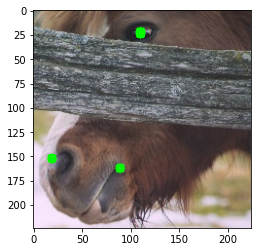

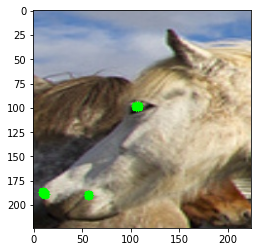

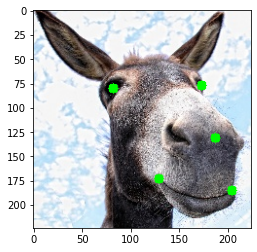

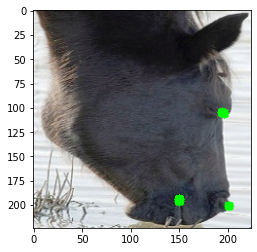

In [8]:
if args.vis:
    inference(args,config,test_loader,student_model)